In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.8
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 9s 767ms/step - loss: 0.0228
Average validation loss: 0.6993882060050964
4/4 [==============================] - 9s 778ms/step - loss: 0.0228 - val_loss: 0.6994
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 12s 785ms/step - loss: 0.0159 - val_loss: 0.6994
Average validation loss: 0.5248984098434448
4/4 [==============================] - 12s 798ms/step - loss: 0.0159 - val_loss: 0.6121
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 15s 778ms/step - loss: 0.0119 - val_loss: 0.6121
Average validation loss: 0.5233389139175415
4/4 [==============================] - 16s 790ms/step - loss: 0.0119 - val_lo

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 700ms/step - loss: 1.2256e-05
Average validation loss: 0.0006397667748387903
8/8 [==============================] - 6s 709ms/step - loss: 1.2256e-05 - val_loss: 6.3977e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 695ms/step - loss: 1.1952e-05 - val_loss: 6.3977e-04
Average validation loss: 0.00020348936595837586
8/8 [==============================] - 11s 705ms/step - loss: 1.1952e-05 - val_loss: 4.2163e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 17s 690ms/step - loss: 1.1905e-05 - val_loss: 4.2163e-04
Average validation loss: 0.0011729117832146585
8/8 [========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 711ms/step - loss: 2.4745e-05
Average validation loss: 0.05193123283485571
12/12 [==============================] - 9s 721ms/step - loss: 2.4745e-05 - val_loss: 0.0519
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 702ms/step - loss: 2.1813e-05 - val_loss: 0.0519
Average validation loss: 0.022855340658376615
12/12 [==============================] - 17s 712ms/step - loss: 2.1813e-05 - val_loss: 0.0374
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 702ms/step - loss: 1.9939e-05 - val_loss: 0.0374
Average validation loss: 0.08570984852713082
12/12 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 735ms/step - loss: 1.5746e-05
Average validation loss: 0.03380893892608583
16/16 [==============================] - 12s 746ms/step - loss: 1.5746e-05 - val_loss: 0.0338
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 758ms/step - loss: 1.5373e-05 - val_loss: 0.0338
Average validation loss: 0.06643564347177744
16/16 [==============================] - 24s 768ms/step - loss: 1.5373e-05 - val_loss: 0.0501
Epoch 3/10
16/16 [==============================] - 36s 714ms/step - loss: 1.4583e-05 - val_loss: 0.0501
Average validation loss: 0.15353253147364385
16/16 [==============================] - 36s 724ms/step - loss: 1.4583e-05 - val_loss: 0.0846
Epoch 4/10
16/16 [==============================] - 48s 735ms/step - loss: 1.4416e-05 - val_loss: 0.0846
Average validatio

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 704ms/step - loss: 1.1284e-05
Average validation loss: 0.15774721503257752
20/20 [==============================] - 14s 715ms/step - loss: 1.1284e-05 - val_loss: 0.1577
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 713ms/step - loss: 1.0570e-05 - val_loss: 0.1577
Average validation loss: 0.06891534445603612
20/20 [==============================] - 29s 724ms/step - loss: 1.0570e-05 - val_loss: 0.1133
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 43s 716ms/step - loss: 9.6001e-06 - val_loss: 0.1133
Average validation loss: 0.017514601978473366
20/20 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 720ms/step - loss: 1.2483e-05
Average validation loss: 0.0228713642184933
24/24 [==============================] - 18s 730ms/step - loss: 1.2483e-05 - val_loss: 0.0229
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 705ms/step - loss: 1.1274e-05 - val_loss: 0.0229
Average validation loss: 0.015084552112966776
24/24 [==============================] - 35s 716ms/step - loss: 1.1274e-05 - val_loss: 0.0190
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 715ms/step - loss: 9.8014e-06 - val_loss: 0.0190
Average validation loss: 0.015552679387231668
24/24 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 704ms/step - loss: 2.5498e-05
Average validation loss: 0.13063396960496904
40/40 [==============================] - 29s 715ms/step - loss: 2.5498e-05 - val_loss: 0.1306
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 57s 718ms/step - loss: 2.2485e-05 - val_loss: 0.1306
Average validation loss: 0.036890178360044955
40/40 [==============================] - 58s 729ms/step - loss: 2.2485e-05 - val_loss: 0.0838
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 86s 701ms/step - loss: 2.0006e-05 - val_loss: 0.0838
Average validation loss: 0.05526292156428099
40/40 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 711ms/step - loss: 1.5204e-05
Average validation loss: 0.0411998462198729
48/48 [==============================] - 35s 722ms/step - loss: 1.5204e-05 - val_loss: 0.0412
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 708ms/step - loss: 1.1476e-05 - val_loss: 0.0412
Average validation loss: 0.01505771120234082
48/48 [==============================] - 69s 718ms/step - loss: 1.1476e-05 - val_loss: 0.0281
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 104s 716ms/step - loss: 8.8499e-06 - val_loss: 0.0281
Average validation loss: 0.012482247839216143
48/48 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 707ms/step - loss: 1.9707e-05
Average validation loss: 0.03536201429545015
56/56 [==============================] - 40s 716ms/step - loss: 1.9707e-05 - val_loss: 0.0354
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 79s 703ms/step - loss: 1.3049e-05 - val_loss: 0.0354
Average validation loss: 0.014384743740915187
56/56 [==============================] - 80s 712ms/step - loss: 1.3049e-05 - val_loss: 0.0249
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 120s 720ms/step - loss: 1.0391e-05 - val_loss: 0.0249
Average validation loss: 0.015972012038608745
56/56 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 44s 690ms/step - loss: 1.3439e-05
Average validation loss: 0.023695206858974416
64/64 [==============================] - 45s 699ms/step - loss: 1.3439e-05 - val_loss: 0.0237
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 90s 705ms/step - loss: 9.0390e-06 - val_loss: 0.0237
Average validation loss: 0.019167674880009145
64/64 [==============================] - 91s 715ms/step - loss: 9.0390e-06 - val_loss: 0.0214
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 136s 703ms/step - loss: 7.0533e-06 - val_loss: 0.0214
Average validation loss: 0.016977355458948296
64/64 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 710ms/step - loss: 1.0388e-05
Average validation loss: 0.0135311932147791
72/72 [==============================] - 52s 719ms/step - loss: 1.0388e-05 - val_loss: 0.0135
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 102s 701ms/step - loss: 7.8714e-06 - val_loss: 0.0135
Average validation loss: 0.011339757669096192
72/72 [==============================] - 103s 711ms/step - loss: 7.8714e-06 - val_loss: 0.0124
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 154s 704ms/step - loss: 6.0872e-06 - val_loss: 0.0124
Average validation loss: 0.010668999670694271
72/72 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 707ms/step - loss: 9.9339e-06
Average validation loss: 0.01742184164468199
80/80 [==============================] - 57s 718ms/step - loss: 9.9339e-06 - val_loss: 0.0174
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 704ms/step - loss: 7.0283e-06 - val_loss: 0.0174
Average validation loss: 0.010338303889147938
80/80 [==============================] - 114s 713ms/step - loss: 7.0283e-06 - val_loss: 0.0139
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 171s 707ms/step - loss: 5.4797e-06 - val_loss: 0.0139
Average validation loss: 0.00962227793643251
80/80 [===========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 74s 768ms/step - loss: 1.6645e-05
Average validation loss: 0.034376346496477105
96/96 [==============================] - 75s 778ms/step - loss: 1.6645e-05 - val_loss: 0.0344
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 148s 767ms/step - loss: 1.0823e-05 - val_loss: 0.0344
Average validation loss: 0.019502543431978363
96/96 [==============================] - 149s 778ms/step - loss: 1.0823e-05 - val_loss: 0.0269
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 223s 770ms/step - loss: 8.5025e-06 - val_loss: 0.0269
Average validation loss: 0.02109662954171654
96/96 [==========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 92s 765ms/step - loss: 9.2975e-06
Average validation loss: 0.011156602545330923
120/120 [==============================] - 93s 776ms/step - loss: 9.2975e-06 - val_loss: 0.0112
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 185s 766ms/step - loss: 6.0674e-06 - val_loss: 0.0112
Average validation loss: 0.011595913255587221
120/120 [==============================] - 186s 776ms/step - loss: 6.0674e-06 - val_loss: 0.0114
Epoch 3/10
120/120 [==============================] - 278s 766ms/step - loss: 4.7427e-06 - val_loss: 0.0114
Average validation loss: 0.009950715024024248
120/120 [==============================] - 279s 777ms/step - loss: 4.7427e-06 - val_loss: 0.0109
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 101s 702ms/step - loss: 8.4294e-06
Average validation loss: 0.06301935927735434
144/144 [==============================] - 102s 712ms/step - loss: 8.4294e-06 - val_loss: 0.0630
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 204s 704ms/step - loss: 6.2106e-06 - val_loss: 0.0630
Average validation loss: 0.014289842879710099
144/144 [==============================] - 205s 714ms/step - loss: 6.2106e-06 - val_loss: 0.0387
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 307s 707ms/step - loss: 4.8231e-06 - val_loss: 0.0387
Average validation loss: 0.02040871183594896
144/144 [=============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 112s 700ms/step - loss: 2.7521e-06
Average validation loss: 0.015388708701357246
160/160 [==============================] - 114s 710ms/step - loss: 2.7521e-06 - val_loss: 0.0154
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 225s 698ms/step - loss: 2.2989e-06 - val_loss: 0.0154
Average validation loss: 0.007061607373179868
160/160 [==============================] - 227s 708ms/step - loss: 2.2989e-06 - val_loss: 0.0112
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 340s 703ms/step - loss: 2.0781e-06 - val_loss: 0.0112
Average validation loss: 0.008431635118904523
160/160 [===========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 141s 704ms/step - loss: 1.5233e-05
Average validation loss: 0.013940168570261448
200/200 [==============================] - 143s 714ms/step - loss: 1.5233e-05 - val_loss: 0.0139
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 283s 699ms/step - loss: 9.9363e-06 - val_loss: 0.0139
Average validation loss: 0.011059915344230831
200/200 [==============================] - 284s 708ms/step - loss: 9.9363e-06 - val_loss: 0.0125
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 426s 705ms/step - loss: 7.6592e-06 - val_loss: 0.0125
Average validation loss: 0.009332613805308938
200/200 [===========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:20 - loss: 5.0707e-05

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 169s 705ms/step - loss: 6.8333e-06
Average validation loss: 0.01720614197353522
240/240 [==============================] - 172s 714ms/step - loss: 6.8333e-06 - val_loss: 0.0172
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 340s 702ms/step - loss: 4.8075e-06 - val_loss: 0.0172
Average validation loss: 0.026985280729907874
240/240 [==============================] - 342s 712ms/step - loss: 4.8075e-06 - val_loss: 0.0221
Epoch 3/10
240/240 [==============================] - 512s 705ms/step - loss: 3.7336e-06 - val_loss: 0.0221
Average validation loss: 0.010983438032174794
240/240 [==============================] - 514s 715ms/step - loss: 3.7336e-06 - val_loss: 0.0184
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_K

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.11522760655299948, 0.05338938437315278, 0.10475216312928938, 0.04364716837618431, 0.021711733351215113, 0.01337890397149143, 0.020240680808894237, 0.014187638026790714, 0.016819722258613702, 0.013376210323416729, 0.010026778811985017, 0.010712409997402575, 0.015255519829685604, 0.010066104703092908, 0.01321916060841128, 0.007681565552426035, 0.00929248462885298, 0.012144780547388717]
std_val_losses =  [0.20802539816446278, 0.05584636379020091, 0.09704235509641317, 0.034022039270479344, 0.023928549721589507, 0.0074959824124645235, 0.018586212354216307, 0.007158713116975095, 0.015873363437780248, 0.004539109719484115, 0.0031741826178166154, 0.005855030328495087, 0.009603003110179718, 0.0031882705631098083, 0.019157015462880653, 0.0026599244430135804, 0.0022198157392314165, 0.007542788868656904]


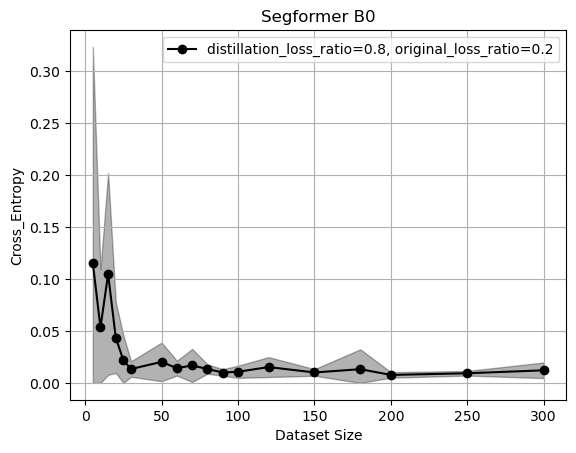

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()